In [82]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Dropout,ELU, BatchNormalization, PReLU, Add, Input,GlobalAveragePooling2D,ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os
import numpy as np
import gzip

def load_emnist(path, kind='train'):
    """Load EMNIST dataset from `path`"""
    labels_path = os.path.join(path, f'emnist-balanced-{kind}-labels-idx1-ubyte.gz')
    images_path = os.path.join(path, f'emnist-balanced-{kind}-images-idx3-ubyte.gz')

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 28, 28, 1)

    return images, labels

# Path where the dataset was extracted
path = '/content/drive/MyDrive/gzip/gzip'

# Load training and test data
train_images, train_labels = load_emnist(path, kind='train')
test_images, test_labels = load_emnist(path, kind='test')
#train_images = train_images / 255.0
#test_images = test_images / 255.0

# Split the test data into validation and test sets
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.5, random_state=42)


# 데이터 증강 함수 정의
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image, label

# TensorFlow 데이터셋 만들기
batch_size = 1024
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [112]:
def residual_block(x, filters, kernel_size=3, stride=1):
    y = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    y = BatchNormalization()(y)
    y = PReLU()(y)
    y = Conv2D(filters, kernel_size, strides=1, padding='same')(y)
    y = BatchNormalization()(y)

    if stride != 1 or x.shape[-1] != filters:
        x = Conv2D(filters, 1, strides=stride, padding='same')(x)
        x = BatchNormalization()(x)

    out = Add()([x, y])
    out = PReLU()(out)
    return out

input = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), padding='same')(input)
x = BatchNormalization()(x)
x = PReLU()(x)
x = Dropout(0.33)(x)
x = AveragePooling2D(pool_size=2, strides=2, padding='valid')(x)

x = residual_block(x, 64)
x = Dropout(0.33)(x)
x = AveragePooling2D(pool_size=2, strides=2, padding='valid')(x)

x = residual_block(x, 128)
x = Dropout(0.33)(x)
x = AveragePooling2D(pool_size=2, strides=2, padding='valid')(x)

x = residual_block(x, 256)
x = Dropout(0.33)(x)
x = AveragePooling2D(pool_size=2, strides=2, padding='valid')(x)

x = Flatten()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = PReLU()(x)
x = Dropout(0.6)(x)

output = Dense(47, activation='softmax')(x)

model = Model(inputs=input, outputs=output)


In [113]:
optimizer = Adam(learning_rate=0.001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.000001)

# 모델 컴파일
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=[reduce_lr])

# 모델 평가
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

Epoch 1/50
56/56 [==============================] - 10s 43ms/step - loss: 1.9820 - accuracy: 0.4565 - val_loss: 2.1474 - val_accuracy: 0.6935 - lr: 0.0010
Epoch 2/50
56/56 [==============================] - 2s 38ms/step - loss: 0.7051 - accuracy: 0.7691 - val_loss: 1.0462 - val_accuracy: 0.7686 - lr: 0.0010
Epoch 3/50
56/56 [==============================] - 2s 37ms/step - loss: 0.5354 - accuracy: 0.8172 - val_loss: 0.5539 - val_accuracy: 0.8335 - lr: 0.0010
Epoch 4/50
56/56 [==============================] - 2s 37ms/step - loss: 0.4667 - accuracy: 0.8376 - val_loss: 0.4310 - val_accuracy: 0.8530 - lr: 0.0010
Epoch 5/50
56/56 [==============================] - 2s 36ms/step - loss: 0.4193 - accuracy: 0.8535 - val_loss: 0.3534 - val_accuracy: 0.8723 - lr: 0.0010
Epoch 6/50
56/56 [==============================] - 2s 36ms/step - loss: 0.3942 - accuracy: 0.8616 - val_loss: 0.3478 - val_accuracy: 0.8753 - lr: 0.0010
Epoch 7/50
56/56 [==============================] - 2s 37ms/step - loss: 0.

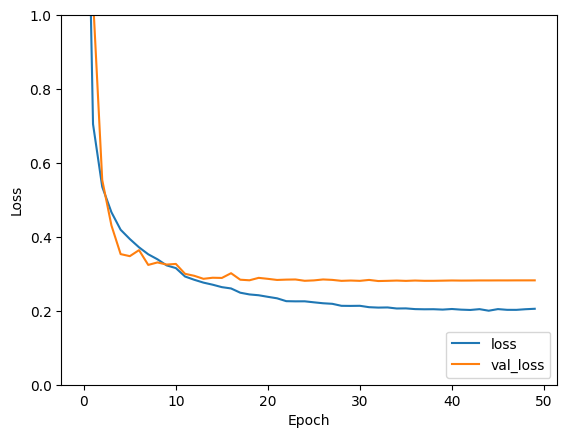

588/588 - 2s - loss: 0.2965 - accuracy: 0.9002 - 2s/epoch - 3ms/step
Test accuracy: 0.9002127647399902


In [114]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc}")